# TMA4320 - Project 1
#### Peder Brekke, Simen Nesland and Espen Bjørge Urheim

All living cells contain a number of organelles; structures within the cell specialized to perform a number of tasks.
Some of these organelles are enclosed by a lipid membrane as a way of concentrating certain enzymes and reactants in a confined space, as well as to separate organelles from the cytocol and its contents. Other organelles are not membrane-bound. These organelles can be formed from liquid-liquid phase separation, creating small areas within the cytoplasm with a higher concentration of proteins than the surrounding area. Important for this process are the electrostatic interactions between polymers, which will be discussed later. The forming of such membrane-less organelles are the ones that will be analyzed further in this project. 

Our project objective is to model this biological system in such a way that ultimately, we can describe a multipolymeric system numerically and form such a system which iteratively "seeks" the lowest total energy possible for the system (given some parametres).To do this, we have first discretizied the cytocol to a square two-dimensional grid. In attempt to simplify the content of our grid, we are only numerically representing the contents of the cytocol that are critical to the formation of membrane-less organelles, leaving out other "spectator molecules".
    

## Systems of polymers with a multivalency of 1


We start by analyzing a system of polymers with a multivalency equaling $1$, meaning that all polymers in that system contain one monomer. After creating our square two-dimensional grid we assign $2M$ monomers to unique grid-points at random, with half being positively charged and the other half being negatively charged.
To represent a monomer occupying a grid-point, all monomers are assigned a unique integer value from the interval $[-M,M]$, where the integer sign represents the charge sign of the monomer. Each point in our grid is now either occupied by a monomer, or it is empty. The reason for implementing a way to represent charge sign in monomer values will become apparent as we try to calculate the energy for such a system.

In [130]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.constants import Boltzmann, pi, epsilon_0, e
from random import randint, uniform, choice

from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

from PIL import Image
import requests
from io import BytesIO

import time

In [2]:
@jit(nopython=True)
def create_grid(M,N):
    """
    Creates 2D array to represent system.
    
    M: Number of positively/negatively charged monomers (int)
    N: Size og sides in grid (int)
    """
    grid = np.zeros((N, N), dtype=np.dtype('i2'))                                     # Creates empty N x N grid  
    
    monomer_values = np.array(list(range(-M,0)) + list(range(1,M+1)))                 # Defines monomer values
    
    # Loop that picks empty positions in grid at random, and assigns monomer values to positions
    index = 0
    while index < len(monomer_values):
        random_coordinate = np.array([random.randint(0,N-1),random.randint(0,N-1)])
        if grid[random_coordinate[0],random_coordinate[1]] == 0:
            grid[random_coordinate[0],random_coordinate[1]] = monomer_values[index]
            index += 1
    return grid


def plot_system(grid, title):
    """
    Simple function to plot grid using matplotlibs pcolormesh.
    
    grid: System representation (2D-array)
    title: Title of plot (string)
    """
    f = plt.figure(figsize=(6,6))
    ax = f.add_subplot(111)
    plt.pcolormesh(grid[::-1])
    plt.title(title, fontsize = 20)
    plt.show()

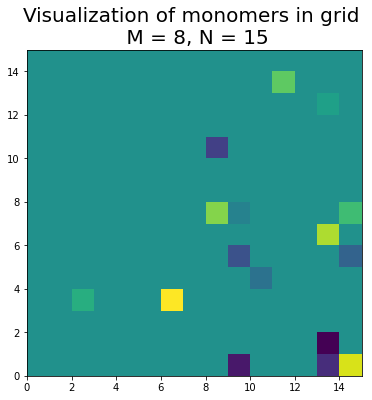

In [3]:
demo_grid = create_grid(8,15)
plot_system(demo_grid, "Visualization of monomers in grid \n M = 8, N = 15")

Now that we can produce a grid of randomly placed monomers, we should find a way to calculate the total energy for this system. 

All though there are in reality multiple intermolecular interactions that contribute to the formation of membrane-less organelles, we are in this project solely focused on the electrostatic forces between polymers. All monomers within a polymer-structure will have a electric charge $ q = we $ with $w = {-1,1}$. To measure a given systems total energy, we only have to calculate the electric potential between monomers using Columbs law. To further simplify our model, all interactions between monomers within a given polymer will be set to zero, as well as interactions between all monomers that are not neighbouring points in our grid. 

This means that we are only interested in the charge sign of "neighbouring points"; points that are directly adjacent to a given point. We therefore create a function that takes in a point, and returns all such neighbouring points. For points along the edges of our grid, we have implemented periodic boundary conditions. This simply means that a point on the leftmost edge will have its left neighbour at the rightmost edge, and vice versa. This also goes for the top and bottom edge, as well as any combination of these. All though this is not a realistic representation of how polymers move within the cytosol, it is implemented to avoid effects on polymer conformation from having "hard edges". 

In [4]:
@jit(nopython=True)
def find_nearest_neighbours(x_index, y_index, N):
    """
    Finds neighbours of point in grid (diagonals not included).
    Returns array with coordinates
    
    x_index: x-coordinate (int)
    y_index: y-coordinate (int)
    N: size of grid (int)
    """
    neighbour_up = [(x_index - 1)%N, y_index]
    neighbour_down = [(x_index + 1)%N,y_index]
    neighbour_right = [x_index,(y_index + 1)%N]
    neighbour_left = [x_index,(y_index - 1)%N]

    neighbour_coordinates = np.array([neighbour_right, neighbour_left, neighbour_up, neighbour_down])
    
    return neighbour_coordinates

Now that we have a function to find all neighbouring points of a given grid-point, we calculate the total energy of our system of monomers. Using Coulombs law, as well as the assumption that all monomers have a charge $ q = we $ with $w = \{-1,1\}$, e being the elementary charge, we can derive an expression for the potential energy between two monomers:

$$
V_{kl} = w_{k}w_{l} \frac{e^{2}}{4 \pi \epsilon_{0} \epsilon_{r} a} \frac{a}{|r_{k} - r_{l}|} =w_{k}w_{l} \alpha \frac{a}{|r_{k} - r_{l}|}
$$

As previously stated, we are not interested in the potential energy of any monomers that are not situated in neighbouring points. This means that we can cancel $ \frac{a}{|r_{k} - r_{l}|}$ from our equation, as $|r_{k} - r_{l}| = a$ is satisfied for all neighbouring points and thus, all situations where we will have a non-zero potential energy. Summing up all such potential energies between monomers, we end up with our final equation for the total energy of our system. 


$$
E = \Sigma V_{kl} = \alpha \Sigma w_{k}w_{l} 
$$

We can now use this to calculate the total energy for our system. To ease the complexity of our numerical solution we introduce a helper function `is_positive_or_negatice()`, as well as the function to calculate the total energy. 

In [5]:
@jit(nopython=True)
def is_positive_or_negative(x_index,y_index,grid):
    """
    Takes in coordinates of a point within a grid. 
    Returns the sign value of given point in grid.
    If value at point given by coordinates is 0, the function returns zero
    """
    if grid[x_index][y_index] < 0:                              # Checks sign of value,                                                               
        return -1                                               # return {-1,0,1} dependent on sign
    elif grid[x_index][y_index] > 0:
        return 1
    else:
        return 0
    
@jit(nopython=True)
def energy_calculation(grid):
    
    """
    Calculates the total energy of system of monomers,
    given a input grid.
    """
    grid_copy = grid.copy()
    
    epsilon_r = 78                                              # Relative permittivity of water at room temperature
    a = 23 * 10**(-6)                                           # Distance between grid points.
    alpha = e**2 /(4*pi*epsilon_0 * epsilon_r * a**2)           # normatilizing constant 
    
    N = np.shape(grid_copy)[0]                                  # Grid size; where grid is N x N array
    E = 0                                                       # Dimensionless energy; E = E_true/alpha
    
    
    monomer_points = np.argwhere(grid_copy != 0)
    
    for point in monomer_points:                                # Loops through all non-zero points in grid
        x_index = point[0]                                      # Unpack coordinates of central point                                          
        y_index = point[1]
        
        # Array of coordinates of all neighbouring points to central point
        neighbour_coordinates = find_nearest_neighbours(x_index,y_index, N) 
        
        # Finds sign of central point; either -1 or 1
        central_point_sign = is_positive_or_negative(x_index,y_index,grid_copy)
        
        # Loops through the four neighbouring points
        for neighbour in neighbour_coordinates:
            # Unpacks neighbour coordinates
            x_index_neighbour = neighbour[0]
            y_index_neighbour = neighbour[1]
            
            # Finds sign of neighbouring point
            neighbour_point_sign = is_positive_or_negative(x_index_neighbour,y_index_neighbour,grid_copy)
            
            # Calculates potential energy between monomers 
            E += central_point_sign * neighbour_point_sign
            
        # Sets central point to zero; this to avoid multiple energy counts of same monomer pair    
        grid_copy[x_index][y_index] = 0
        
    # Returns total energy of system [J]
    return E  * alpha                                               

In [6]:
demo_energy_calc = energy_calculation(demo_grid)
print(demo_energy_calc)

-5.591288721685171e-21


Having established a way of creating a multi-monomerical system and assessing the total energy of said system, our next step is implementing a way for monomers to move around; causing changes in interactions between monomers and therefore also in the total energy of the system. To do this, we make use of a Monte Carlo method; more spesifically the Metropolis algorithm.

Taking in a grid of monomers and empty spaces as produced earlier, our function will try to move this monomer randomly to one of its neighbouring points, given that a series of criteria are fulfilled: Firstly, the new grid-point for which the monomer is "requesting" to move to has to be available; its value can't be non-zero. If the grid-point is available, we then compare the total energy of our new system to our system before the move was attempted. If the move grants a lower total energy system, the move is accepted and is stored in a new grid. Biologically this represents a physical move of said monomer in the cytosol, causing a reconfiguration of our system of monomers. This type of movement will be the mechanism for how our system "seeks" out a total energy minima. In the case that our attempted move gives the same, or a higher total energy for our system, the move may still be accepted, this due to thermal fluctuations. The probability of such a move is determined by the following probability distribution:

\begin{equation} \label{eq1}
P_{move}(\Delta E, T) = e^{-\beta\Delta E} , \beta = \frac{1}{k_{b}T}
\end{equation}

To determine wether the move is initialized or not, we randomly generate a number p with value between 0 and 1. if $P_{move} > p$, the move is initialized and is stored in our new grid. If the move is denied, either because the grid-point is already taken or the generated p is greater than $P_{move}$, no further action is done and the grid remains unchanged.

This is the process in which one step of our Metropolis algorithm is completed. To complete our simulation, we now repeat this step Ns number of times, before inspecting our results. Since we have introduced a certain randomness to this simulation we do not expect the excact same output for each run, and are therefore solely interested in the emerging trends of our system.

In [7]:
@jit(nopython=True)
def random_monomer(grid):
    """
    Picks random monomer in given grid. Returns a tuple with x- and y-coordinate.
    
    grid: grid of system (2D-array)
    """
    N = np.shape(grid)[0]                                 # Size of grid
    x = 0
    y = 0
    
    while True:
        x = randint(0, N - 1)                             # Random x-coordinate
        y = randint(0, N - 1)                             # Random y-coordinate
        if grid[y][x] != 0:                               # Breaks if monomer is found
            break
    return (x, y)

@jit(nopython=True)
def legal_move(grid, move_list):
    """
    Checks if move is legal. Returns true/false.
    
    grid: grid of system (2D-array)
    move_list: move to be made (list of 2 tuples: [(x, y), (dx, dy)])
    """
    x, y = move_list[1]
    if grid[y][x] == 0:                                   # Ok if no monomer in destination
        return True
    else:
        return False

@jit(nopython=True)
def get_new_position(grid, coordinates):
    """
    Returns new coordinates after move, using periodic boundary conditions
    
    grid: grid of system (2D-array)
    coordinates: tuple with x and y coordinates
    """
    x, y = coordinates
    neighbours = find_nearest_neighbours(y, x, np.shape(grid)[0])         # Finds possible moves
    random_index = np.random.randint(0,4)                                 # Picks random move
    neighbour_array = neighbours[random_index]                        
    return neighbour_array[0], neighbour_array[1]

@jit(nopython=True)
def init_move(grid, move_list):
    """
    Initializes move in grid. Returns updated grid
    
    grid: grid of system (2D-array)
    move_list: move to be made (list of 2 tuples: [(x, y), (dx, dy)])
    """
    grid_copy = grid.copy()
    x0, y0 = move_list[0]                                          # Unpacks move_list-values
    x, y = move_list[1]
                    
    value = grid_copy[y0][x0]
    grid_copy[y0][x0] = 0                                          # Sets old position to value 0
    grid_copy[y][x] = value                                        # Updates new coordinate
    
    return grid_copy

def monte_carlo(N, M, Ns, T, te = 0, tr = 1000, cluster_size = False, energy = False):
    """
    Monte Carlo algorithm to simulate behaviour of monomers.
    Returns initial grid, final grid, and selected measurements
    
    N: size of sides in grid (int)
    M: number of monomers (int)
    Ns: number of steps in simulation (int)
    T: absolute temperature [K] (int/float)
    te: steps until equilibrium (int)
    tr: interval between measurements (int)
    cluster_size: whether or not measure cluster size (bool)
    energy: whether or not measure energy (bool)
    """
    beta = 1/(Boltzmann*T)                                  # beta in Boltzmann factor
    grid = create_grid(M,N)                                 # Creates a grid
    grid0 = grid.copy()
    
    if cluster_size:
        mean_sizes = np.zeros(int((Ns-te)/tr))                             # Array to store mean cluster-values
        
    if energy:
        energy_array = np.zeros(Ns)                                        # Array to store energy-values
        energy_array[0] = energy_calculation(grid)

    for i in range(Ns - 1):
        E = energy_calculation(grid)
        monomer = random_monomer(grid)                      # Picks random monomer
        x, y = get_new_position(grid, monomer)              # Finds random move
        move_list = [monomer, (x, y)]
        
        if legal_move(grid, move_list):                     # Creates new grid if move is legal. Finds new energy
            new_grid = init_move(grid, move_list)
            E_new = energy_calculation(new_grid)
                
            if E_new < E:                                   # Updates actual grid and energy if new energy is lower
                grid = new_grid
                E = E_new
            
            else:                                           # Might update grid anyway depending on randomness
                random_probability = uniform(0, 1)          # ...and the Boltzmann factor
                delta_E = E_new - E
                boltzmann_factor = np.exp(-beta*delta_E)
            
                if random_probability < boltzmann_factor:
                    grid = new_grid
                    E = E_new
        
        if energy:
            energy_array[i+1] = E                                # Updates energy array
        
        if i >= te and (i - te)%tr == 0 and cluster_size:        # Measures mean cluster size
            cluster_grid = create_cluster_grid(grid)
            mean_sizes[int((i - te)/tr)] = mean_cluster_size(cluster_grid, M)
    
    if cluster_size and energy:     
        return grid0, grid, energy_array, mean_sizes
    elif cluster_size and not energy:
        return grid0, grid, mean_sizes
    elif energy and not cluster_size:
        return grid0, grid, energy_array
    else:
        return grid, grid0

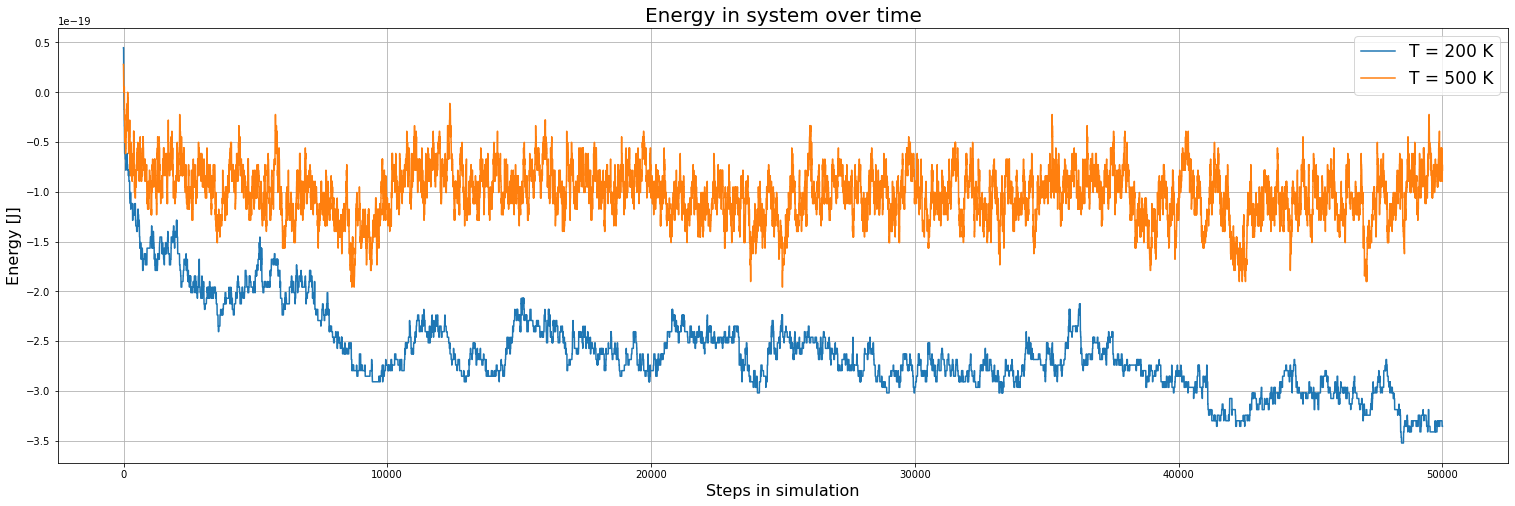

In [88]:
Ns = 50000
N = 15
M = 25
Ts = [200, 500]

plt.figure(figsize = (26,8))
t = np.linspace(0,Ns-1,Ns)
legends = []

for T in Ts:
    grid0, grid, energy = monte_carlo(N, M, Ns, T, energy = True)
    plt.plot(t, energy)
    legends.append(f"T = {T} K")
    if T == 200:
        np.savez("1f_grid.npz", grid)
    

plt.title("Energy in system over time", fontsize = 20)
plt.xlabel("Steps in simulation", fontsize = 16)
plt.ylabel("Energy [J]", fontsize = 16)
plt.legend(legends, prop={'size': 17})
plt.grid()

From the figure above, we can clearly see that the graph for T = 500 K has bigger and more frequent fluctuations than T = 200 K. It also seems to approach a state of equilibrium at a faster rate. The number of steps this takes, we denote as 
$t_{equil}$. A quick visual analysis of our two graphs seems to suggest that a system with a higher temperature will have a smaller $t_{equil}$, compared to a system with a lower temperature. For T = 500 K, we estimate that $t_{equil}$ is situated around 10.000 to 20.000 steps in, while as for T = 200 K this value seem to be significantly greater, presumably beyond 50.000 steps. 

This can be explained by realising that the probability factor $P_{move}$ is dependent on the temperature of the system. Looking at equation (2), we see that an increase in temperature will give a higher probability for monomers to move in a unfavorable way energy-wise. 
This brings us to the concept of "local energy minimas", which are conformations of monomers which grant the lowest total energy relative to all possible new conformations resulting from a certain number of new monomer moves from the original conformation. Simply said monomers can become "stuck" in a certain conformation, even though this is not the lowest possible energy state available for the system.

### Clustering of monomers

When simulating random moves for the monomers, contact between different monomers often occur. After all this "contact" is the only energy out simplification takes into cosideration. The formation of these aggregates is interesting. When examining our previous discussion of energy minima, our model predicts that the formation of aggergates is favorable. This does indeed become very obvious concidering the famous saying "opposites attract". Therefore, the size of and number of these clusters of monomer has close ties with the energy in the system an thus is of interest.

We define a cluster when multiple monomers are connected. In our system, connected means that the monomers are each others nearest neighbours. In other words, for a cluster to exist, one must be able to create a path that does not cross the solvent and does not move diagonally, from one end to the other. Using these rules we construct a function `create_cluster_grid()` that manipulates the values of an input grid so that all connected monomers have the same integer representation in our 2D-array. To illustrate this, we've constructed a simple example below.

$$ \begin{bmatrix}
1 & -2 & 0 & 0 \\
-1 & 0 & 0 & 0 \\
0 & 2 & -3 & 0 \\
0 & 0 & 0 & 3 
\end{bmatrix} 
 --> 
 \begin{bmatrix}
1 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 2 & 2 & 0 \\
0 & 0 & 0 & 3 
\end{bmatrix}  $$

In [9]:
@jit(nopython=True)
def check_neighbours(x_index, y_index, cluster_index, cluster_grid, grid):
    """
    Recursive function that iterates through the 4 nearby neighbours (NN) of a monomer. 
    If a NN is a monomer, it is given the same value as the original monomer. Then it 
    iterates through the NN of the new monomer, etc.
    Returns an updated cluster_grid (with one new cluster).
    """

    # Finds the 4 NN and iterates through them
    N = np.shape(grid)[0]
    neighbour_list = find_nearest_neighbours(x_index, y_index, N)
    for neighbour in neighbour_list:
        x_neighbour, y_neighbour = neighbour[0], neighbour[1]

        # Checks if a NN is a monomer (value in grid != 0)
        if grid[x_neighbour, y_neighbour] != 0:
            cluster_grid[x_neighbour, y_neighbour] = cluster_index

            # Gives the monomer value 0 in the original grid, to ensure the function only checks it once.
            grid[x_neighbour, y_neighbour] = 0

            # Recursive check of the new monomer.
            cluster_grid = check_neighbours(x_neighbour, y_neighbour, cluster_index, cluster_grid, grid)

    # Returns the updated cluster_grid when no more neighbours are found.
    return cluster_grid

@jit(nopython=True)
def create_cluster_grid(grid):
    """
    Takes in a grid and returns a new cluster_grid where all monomers that are connected to each other
    are represented by the same unique value.
    """
    grid_copy = grid.copy()
    # Create an empty NxN matrix that will be filled with numbers that represent each cluster.
    N = np.shape(grid_copy)[0]
    cluster_grid = np.zeros((N,N))

            
    # cluster_index holds the value that is given to each monomer in the same cluster.
    cluster_index = 1
    
    # Iterate through all points in the input grid:
    for y_index in range(N):
        for x_index in range(N):
            
            # If the grid value is not 0, but the cluster_grid value is, the monomer has not been accounted for. If
            # so, the monomer and all connected monomers is given the value cluster_grid by 
            # the use of check_neighbours().
            if grid[x_index, y_index] != 0 and cluster_grid[x_index, y_index] == 0:
                cluster_grid[x_index, y_index] = cluster_index
                cluster_grid = check_neighbours(x_index, y_index, cluster_index, cluster_grid, grid_copy)
                
                # Updates the value of cluster_index
                cluster_index += 1
    
    return cluster_grid

Text(0.5, 1.0, 'Grid showing clusters')

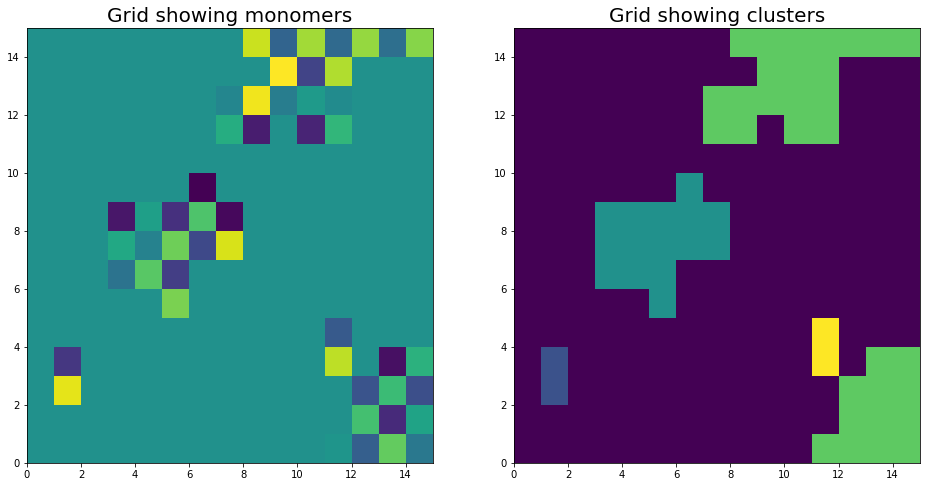

In [34]:
# Getting saved data and converting to a cluster grid
grid_monomers = np.load('1f_grid.npz')["arr_0"]
grid_clusters = create_cluster_grid(grid_monomers)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
ax1.pcolormesh(grid_monomers)
ax2.pcolormesh(grid_clusters)
ax1.set_title("Grid showing monomers", fontsize = 20)
ax2.set_title("Grid showing clusters", fontsize = 20)

Using our newly defined functions, we have managed to construct a representation of the clusters in our system. Above is the same grid from our first simulation, after $30000$ steps, using $T = 200K$. We have plotted the grid of monomers, and the corresponding cluster grid side by side. Take notice of how the boundary condition comes into play, and how our definition does not allow a path within a cluster to be diagonal.

### Cluster sizes at different temperatures

Not only is the fact that clusters appear is interesting, but their sizes can also tell us a lot about our system (or the mean size in particular). Looking at the monte carlo algorithm there are two ways in which a move can be initiated. If the move is energy beneficial, meaning the new energy is lower, the move will be made. However, even though a move is not energy beneficial it can be made, depending on the boltzmann distribution, as explained earlier. Looking at this distribution it becomes clear that $P_{move}$ increases with $T$. Since our move is made if $P_{move}$ > $p$, where $p$ is a random decimal number in $[0, 1]$, we expect more disadvantageous moves (energy wise) with higher temperature. We have just stated that the formation of clusters is energy beneficial, so therefore our model predicts the mean cluster size to decrease with increasing temperature.

Using our monte carlo algorithm, discretized model, and newfound interest for clusters and their sizes we can run a simulation calculating the mean cluster values after the system has reached equilibrium. To test our predictions above, we will calculate the mean cluster size at ten different temperatures from $T = 100K$ to $T = 1000K$ with steps of $100K$. Since our model has a clear dependency of randomness we will run the simulation twice to compare results. We have written a handy function `mean_cluster_size()` that calculates the mean cluster size for a given system. Using a provided formula 
$$t_{equil}= t_{max} e^{-s(T-T_l)}+C$$ 

for the number of steps until equilibrium is reached, where $t_{max} = 100000$, $s = \frac{1}{200}$, $C = 10000$, $T$ is current temperature and $T_l$ is the lowest temperature, we can choose how many measurements we want to make. The measurements of mean cluster size in the monte carlo function has been implemented in such a way that it does not measure anything until $t_{equil}$ steps has been made. After this a measurement will be made every $t_r$ step $n$ times. In practice, this means that if $t_{equil} = 100'000$, $t_r = 1000$ and $n = 100$, the monte carlo function will do $100'000 + 1000 \cdot 100 = 200'000$ steps. Even though our representation of the real world is subject to clear simplifications, the complexity of the simulations is noticeable. To have manageable run times, but still respectable accuracy, we do a quick test to get some idea of how precise our measurements are.


In [133]:
N = 15
M = 25
T = 100

n = 100
t_max = 100000
s = 1/200
C = 10000
tr = 1000

te = int(t_max*np.exp((-s)*(T - Ts[0])) + C)
Ns = int(te + n*tr)
grid0, grid, mean_sizes = monte_carlo(N, M, Ns, T, te = te, tr = tr, cluster_size = True)
print("Average:", np.sum(mean_sizes)/np.shape(mean_sizes)[0])
print("Standard deviation:", np.std(mean_sizes))

Average: 8.03154761904762
Standard deviation: 0.804309845912191


From our test we get a standard deviation of $0.80$. We believe this number to be a bit too large compared to the average of $8.03$. If we increase the number of measurements to $n = 400$ the standard deviation will decrease with a factor of approximately $\frac{1}{2}$ resulting in a standard deviation of approximately $0.40$. Obviously, this estimate is not particularly accurate, as the standard deviation will vary a lot for every simulation. However, it gives an indication that our measurements should be sufficiently precise, for the purpose of this project.

In [69]:
@jit(nopython=True)
def mean_cluster_size(cluster_grid, M, L = 1):
    """
    Calculates mean cluster size of cluster grid
    
    cluster_grid: cluster grid of system (2D-array)
    M: number of positive/negative monomers (int)
    L: Multivalency of polymers. Defult is set to 1, as this is true for monomers (int)
    """
    num = np.amax(cluster_grid)
    mean = (2*M*L)/num                                             # Calculates mean
    return mean

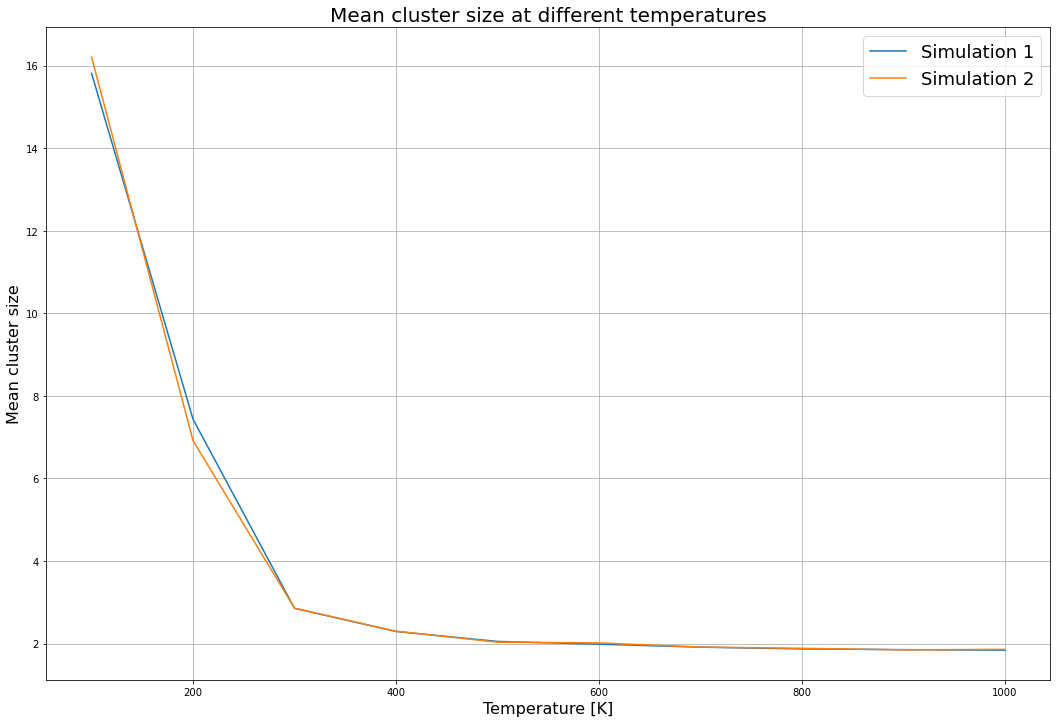

In [86]:
N = 15
M = 25
Ts = np.linspace(100, 1000, 10)
means = []

n = 400
t_max = 100000
s = 1/200
C = 10000
tr = 1000

for j in range(2):
    for i, T in enumerate(Ts):
        te = int(t_max*np.exp((-s)*(T - Ts[0])) + C)
        Ns = int(te + n*tr)
        grid0, grid, mean_sizes = monte_carlo(N, M, Ns, T, te = te, tr = tr, cluster_size = True)
        mean_size = np.sum(mean_sizes)/np.shape(mean_sizes)[0]
        means.append(mean_size)
    
plt.figure(figsize = (18,12))
plt.plot(Ts, means[:len(Ts)])
plt.plot(Ts, means[len(Ts):])
plt.title("Mean cluster size at different temperatures", fontsize = 20)
plt.xlabel("Temperature [K]", fontsize = 16)
plt.ylabel("Mean cluster size", fontsize = 16)
plt.legend(["Simulation 1", "Simulation 2"], prop={'size': 18})
plt.grid()

Looking at the plot above, it seems that our predictions of cluster size decreasing with increasing temperatures are quite correct. An interesting observation is that the deviation between the two simulations is significantly more apparent for lower temperatures. For $T \geq 300K$ it becomes almost impossible to distinguish the two simulations. Our theory is that the lower temperature simulations are much more vulnerable to their initial grids. And since the initial grids are subject to a large degree of randomness, the results vary more for lower temperatures. The reasoning behind this theory is closely related to the concept of local energy minima and global energy minimas. Our simulations seek lower global energy, however, a simulation can get stuck in a local energy minima. We see this as a kind of 'well' in the energy plots. Sometimes the monomers get organized in such a way that in a particular area on the grid, the energy has reached a minimum. Therefore, even though configurations where the energy is much lower are possible, the grid resists leaving its local minima. This problem is well known, and we have included an image below that illustrates this, where an algorithm seeking a global maxima gets stuck at a local maxima. The reason this happens more often at lower temperatures is the boltzmann distribution. At lower temperatures our simulation is more unlikely to make a move that is not 'energy beneficial'. Therefore, if a local minima occurs, the simulation will struggle more to exit this 'well'.

A result we found a little bit surprising was the correlation between the two different simulations at rather low temperatures. As mentioned earlier, the results for $T \geq 300K$ are almost indistinguishable for the two different simulations. There almost seems like there is some sort of boundary between $T = 200K$ and $T = 300K$ somewhere, since the two results suddenly align almost perfectly. This should not be the case because the boltzmann distribution is a continuous function. We believe that the reason for this apparent 'sudden shift' in alignment is due to the interval of our temperatures compared to the growth of the boltzmann distribution. The distribution 'effect' of increasing temperature decreases quite rapidly, while the interval between two temperatures in our measurements is $100 K$. We predict that we would observe a more smooth alignment if we were to use shorter temperature intervals.

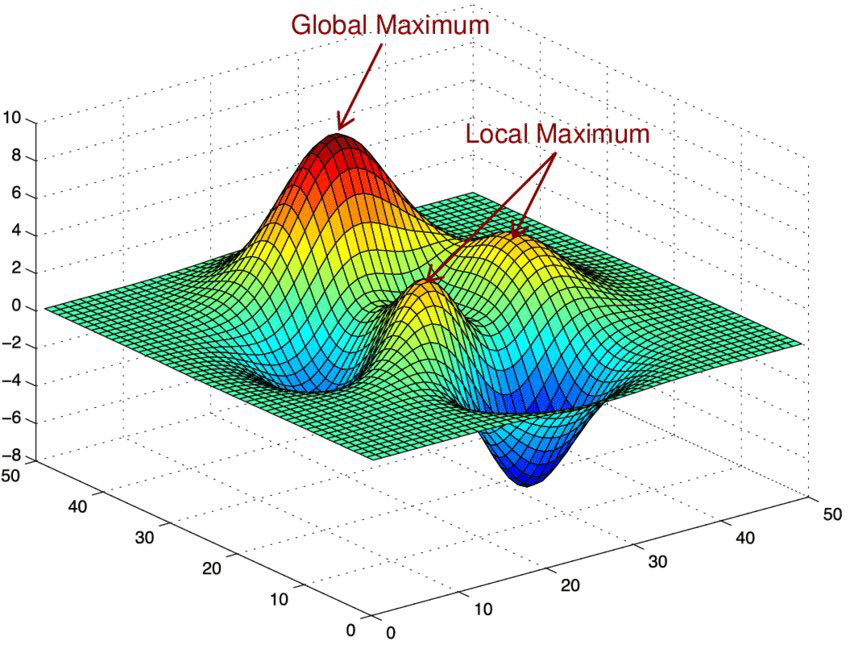

In [126]:
url="https://miro.medium.com/max/1575/1*bpE-3aBYsetOLL0GG8pGDQ.jpeg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

Source: https://miro.medium.com/max/1575/1*bpE-3aBYsetOLL0GG8pGDQ.jpeg

## Multipolymeric systems

We now turn our focus to multipolimeric systems, extending our first algorithm to allow for a multivalency greater than 1. Simply put, we now allow having multiple monomers to belong to a given polymer. Such monomers will be represented in our grid by a shared unique interger value, where they form an unbroken polymer. An unbroken polymer is defined as a polymer where all monomers belonging to the polyer are connected by a path, where the path is piece-wise horizontal or vertical. Diagonally connected polymers does not count as a path. 
One fault with this function is that it can in some runs crash, if the creation of a polymer does not have enough open spaces around it. That being said, as long as N is sufficiently large in relation to M this will so rarely happen that we have deemed it an issue not necessary to fix.


In [14]:
def create_polymer_grid(M,N,L):
    grid = np.zeros((N,N))   # Constructs N x N grid  
    # 2 * M = number of polymers
    # L = multivalency; number of monomers in each polymer
    
    # Makes unique value for each polymer; where sign represents charge of polymer
    polymer_values = np.array(list(range(-M,0)) + list(range(1,M+1)))
    polymer_count = 0                                       # Number of polymers successfully placed in grid

    while polymer_count < len(polymer_values):
        
        monomer_count = 0                                   # Number of monomers in given polymer successfully placed grid
        neighbouring_coordinates = []                       # Makes empty list for storing neighbouring coordinates
        
        random_coordinate = np.array([random.randint(0,N-1),random.randint(0,N-1)])           # Generates random coordinates
        random_x_coordinate = random_coordinate[0]                                            # Unpacks coordinates
        random_y_coordinate = random_coordinate[1]
            
        if grid[random_x_coordinate,random_y_coordinate] == 0:                                # Checks if coordinate point is empty
            grid[random_x_coordinate,random_y_coordinate] = polymer_values[polymer_count]     # Places polymer_value in empty spot 
            monomer_count += 1                                                                # Adds one to total monomer in given polymer
              
            nearest_neighbours = find_nearest_neighbours(random_x_coordinate, random_y_coordinate, N) #Finds nearest neighbour of placed monomer

            for neighbour in nearest_neighbours:                                              # Loops through all neighbouring gridspaces
                neighbour_x_coordinate = neighbour[0]
                neighbour_y_coordinate = neighbour[1]
                if grid[neighbour_x_coordinate,neighbour_y_coordinate] == 0:                  # Appends all non-occupied(zero-valued) neighbouring coordinates to list
                    neighbouring_coordinates.append(neighbour)
                 
            while monomer_count < L:
                random_index = random.randint(0,len(neighbouring_coordinates)-1)              # Defines a random index 
                random_neighbour_coordinate = neighbouring_coordinates.pop(random_index)      # Pops random coordinates from potential neighbours

                
                random_neighbour_x_coordinate = random_neighbour_coordinate[0]                # Unpacks coordinates
                random_neighbour_y_coordinate = random_neighbour_coordinate[1]
                
                grid[random_neighbour_x_coordinate,random_neighbour_y_coordinate] = polymer_values[polymer_count]             # Places polymer_value in empty spot
                monomer_count += 1
                nearest_neighbours = find_nearest_neighbours(random_neighbour_x_coordinate, random_neighbour_y_coordinate, N) # Finds nearest neighbour of placed monomer
                
                for neighbour in nearest_neighbours:    
                    neighbour_x_coordinate = neighbour[0]
                    neighbour_y_coordinate = neighbour[1]
                    if grid[neighbour_x_coordinate,neighbour_y_coordinate] == 0: 
                        neighbouring_coordinates.append(neighbour)              # Appends all zero-valued neighbouring coordinates to list
            polymer_count += 1
            

    return grid


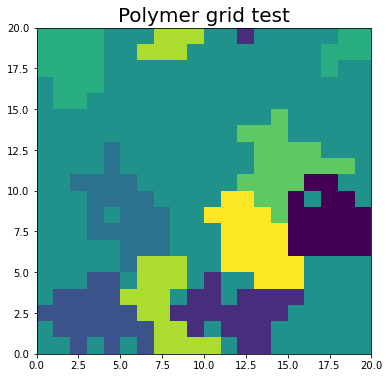

In [15]:
a = 91 * 10 ** (-6)
N = 20
M = 4
L = 25
grid = create_polymer_grid(M, N, L)
plot_system(grid, "Polymer grid test")

We also extend our function to calculate a systems total energy. 

In [16]:
@jit(nopython=True)
def energy_calculation_for_polymers(polymer_grid):
    """
    Calculates the total energy of a system of monomers,
    given an input grid.
    After calculation, sets monomer-value in grid to zero;
    this to avoid multiple counts of the same energy
    """
    grid_copy = polymer_grid.copy()
    
    epsilon_0 = 8.85 * 10 **(-12)                               # Permittivity of free space [Farhad/meter]
    epsilon_r = 78                                              # Relative permittivity of water at room temperature
    a = 91 * 10**(-6)                                           # Distance between grid points. [meters]
    pi = np.pi                                                  # Value of pi
    e  = 1.6 * 10 **(-19)                                       # elementary charge  [Coulomb]
    alpha = e**2 /(4*pi*epsilon_0 * epsilon_r * a**2)           # normalizing constant [Joule]
    
    N = np.shape(grid_copy)[0]                                  # Grid size, where grid is N x N array
    E = 0                                                       # Dimensionless energy; E = E_true/alpha
    
    
    monomer_points = np.argwhere(grid_copy != 0)                # Coordinates of non-zero points in grid
    
    for point in monomer_points:                                # Loops through all non-zero points in grid
        x_index = point[0]                                      # Unpack coordinates of central point                                          
        y_index = point[1]
        
        # Array with coordinates of all neighbouring points to a central point
        neighbour_coordinates = find_nearest_neighbours(x_index,y_index, N) 
        
        # Finds sign of central point; either -1 or 1, and value(indicating which polymer)
        central_point_sign = is_positive_or_negative(x_index,y_index,grid_copy)
        central_point_value = grid_copy[x_index][y_index]
        
        # Loops through the four neighbouring points
        for neighbour in neighbour_coordinates: 
            # Unpacks neighbour coordinates
            x_index_neighbour = neighbour[0]
            y_index_neighbour = neighbour[1]
            
            # Finds sign and value of neighbouring point
            neighbour_point_sign = is_positive_or_negative(x_index_neighbour,y_index_neighbour,grid_copy)
            neighbour_point_value = grid_copy[x_index_neighbour][y_index_neighbour]
            
            # Checks if monomers are part of same polymer
            if central_point_value != neighbour_point_value:  
                # Calculates potential energy between monomers 
                E += central_point_sign * neighbour_point_sign
            
        # Sets central point to zero; this to avoid multiple energy counts of same monomer pair    
        grid_copy[x_index, y_index] = 0
        
    return E * alpha

We will now implement one way that a polymer can move; a rigid move. A rigid move is defined as a polymer move where all relative positions between monomers within the polymer remain unchanged. For this move to be initialized, all grid-positions in the direction of the move must be available. 

In [17]:
@jit(nopython=True)
def init_rigid_move(grid, coord, direction):
    """
    Creates new, updated grid where input move is made (according to rules of rigid move)
    Returns same grid if move is illegal
    
    grid: grid of system (2D-array)
    coord: x and y coordinates of a monomer in the polymer that is to be moved (tuple)
    direction: direction to move polymer, 0: right, 1: left, 2: up, 3: down (int)
    """
    grid_copy = grid.copy()
    N = np.shape(grid_copy)[0]
    
    x_dir, y_dir = [1,-1,0,0], [0,0,1,-1]                              # Upacks values
    dx, dy = x_dir[direction], y_dir[direction]
    x, y = coord[0], coord[1]
    
    polymer = grid[y][x]                                               # Finds unique number of polymer
    same_cluster = np.argwhere(grid_copy == polymer)                   # Coordinates of all points in polymer
    destinations = np.zeros((0, 2), dtype=np.dtype('i2'))                                    # Array to store destinations of points
    
    # Finds all destinations using find_nearest_neighbours()
    for i, point in enumerate(same_cluster):
        dest = np.zeros((1,2), dtype=np.dtype('i2'))
        dest[0] = find_nearest_neighbours(point[0], point[1], N)[direction]
        destinations = np.vstack((destinations, dest))
    
    # Keeps going untill all monomers have moved
    while np.shape(same_cluster)[0] != 0:
        x = same_cluster[0][1] 
        y = same_cluster[0][0]
        dest_x = int(destinations[0][1])
        dest_y = int(destinations[0][0])
        
        # If monomer hasn't moved
        #  - Move it if its destination is empty
        #  - Stop and return original grid if destination belongs to other polymer
        #  - Place in back of queue if none of the above were satisfied
        if grid_copy[dest_y][dest_x] == 0:
            grid_copy[y][x] = 0
            grid_copy[dest_y][dest_x] = polymer
            same_cluster = same_cluster[1:]
            destinations = destinations[1:]
        elif (grid_copy[dest_y][dest_x] != 0) and (grid_copy[dest_y][dest_x] != polymer):
            return grid          
        else:
            same_cluster_first_element = np.zeros((1,2), dtype=np.dtype('i2'))
            same_cluster_first_element[0] = same_cluster[0]
            destinations_first_element = np.zeros((1,2), dtype=np.dtype('i2'))
            destinations_first_element[0] = destinations[0]
            same_cluster = np.vstack((same_cluster[1:], same_cluster_first_element))
            destinations = np.vstack((destinations[1:], destinations_first_element))
   
    return grid_copy

We also implement an updated algorithm for the Monte Carlo simulation. This function `monte_carlo2()` implements the rigid an medium flexibility moves (this will be discussed later).

In [71]:
def monte_carlo2(N, M, Ns, T, L, flex = False, te = 0, tr = 1000, cluster_size = False, energy = False):
    """
    Monte Carlo algorithm to simulate behaviour of monomers.
    Returns initial grid, final grid, and selected measurements
    
    N: size of sides in grid (int)
    M: number of monomers (int)
    Ns: number of steps in simulation (int)
    T: absolute temperature [K] (int/float)
    L: multivalency (int)
    flex: whether or not to allow medium flexibility (bool)
    te: steps until equilibrium (int)
    tr: interval between measurements (int)
    cluster_size: whether or not measure cluster size (bool)
    energy: whether or not measure energy (bool)
    """
    beta = 1/(Boltzmann*T)                                  # beta in Boltzmann factor
    grid = create_polymer_grid(M, N, L)                     # Creates a grid
    grid0 = grid.copy()
    
    if cluster_size:
        mean_sizes = np.zeros(int((Ns-te)/tr))                             # Array to store mean cluster-values
        
    if energy:
        energy_array = np.zeros(Ns)                                        # Array to store energy-values
        energy_array[0] = energy_calculation_for_polymers(grid)

    for i in range(Ns - 1):
        E = energy_calculation_for_polymers(grid)
        x, y = random_monomer(grid)                      # Picks random monomer
        direction = randint(0, 3)
        if flex:
            new_grid = init_medium_flex(grid, (x, y), direction)
        else:
            new_grid = init_rigid_move(grid, (x, y), direction)
        
        if not np.all(new_grid == grid):                        # Creates new grid if move is legal. Finds new energy
            E_new = energy_calculation_for_polymers(new_grid)
                
            if E_new < E:                                   # Updates actual grid and energy if new energy is lower
                grid = new_grid
                E = E_new
            
            else:                                           # Might update grid anyway depending on randomness
                random_probability = uniform(0, 1)          # ...and the Boltzmann factor
                delta_E = E_new - E
                boltzmann_factor = np.exp(-beta*delta_E)
            
                if random_probability < boltzmann_factor:
                    grid = new_grid
                    E = E_new
        
        if energy:
            energy_array[i+1] = E                                # Updates energy array
        
        if i >= te and (i - te)%tr == 0 and cluster_size:
            cluster_grid = create_cluster_grid(grid)
            mean_sizes[int((i - te)/tr)] = mean_cluster_size(cluster_grid, M, L = L)
    
    if cluster_size and energy:     
        return grid0, grid, energy_array, mean_sizes
    elif cluster_size and not energy:
        return grid0, grid, mean_sizes
    elif energy and not cluster_size:
        return grid0, grid, energy_array
    else:
        return grid0, grid

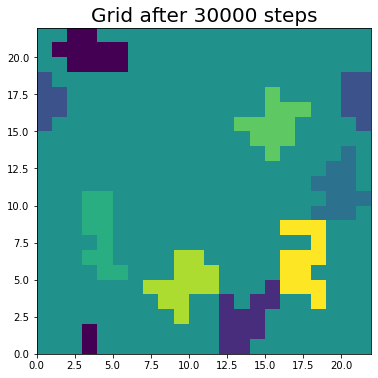

In [55]:
Ns = 30000
N = 22
M = 4
L = 13
T = 200

grid0, grid, energy_rigid = monte_carlo2(N, M, Ns, T, L, energy = True)
np.savez("2d_grid.npz", grid)
plot_system(grid, f"Grid after {Ns} steps")

From the figure above, we can see that there are few polymers with many points of contact to other polymers. This is largely a result of the varying shapes of the polymers. Since the polymers cannot alter their shape when using the rigid move, they are completely dependent on the initial grid, where they get formed. If the polymers do not fit well together, there is nothing our simulations can do about it. Hence we expect a grid like the one above.

In [132]:
Ns = 30000
N = 22
M = 4
L = 13
T = 200

time0 = time.time()
grid0, grid, energy = monte_carlo(N, M, Ns, T, energy = True)
print("Time, monomers:", time.time() - time0)

time1 = time.time()
grid0, grid, energy_rigid = monte_carlo2(N, M, Ns, T, L, energy = True)
print("Time rigid moves:", time.time()-time1)

Time, monomers: 2.2789580821990967
Time rigid moves: 4.263704061508179


In the cell above, we have run a test to compare the run times when moving monomers and when using the rigid move. From the output, we observe that doing the same amount of steps with rigid moves takes almost twice as long as for moving monomers. This is not surprising from an algorithmic point of view. After all, when moving a monomer we update two values in our grid; we set the old coordinate to $0$ and the new coordinate to the monomer value. When moving a polymer rigidly with our current settings $L = 13$, we have to update $2 \cdot 13 = 26$ values in our grid. It is quite obvious this is a more time consuming process than updating two values.

### Medium flexibility move

Now that we have tried simulating with rigid movement, we introduce another way that the polymers might move: medium flex. Here, the polymers can change their shape whenever they hit another polymer in such a way that each row or column of monomers either moves or does not move, which allows for some monomers in a polymer to move while others stand still. This is illustrated in the matrices below, where polymer with index 1 is instructed to move downwards.

$$ \begin{bmatrix}
1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
0 & 2 & 2 & 0 \\
0 & 2 & 2 & 0 
\end{bmatrix} 
 --> 
 \begin{bmatrix}
0 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 2 & 2 & 0 \\
0 & 2 & 2 & 0 
\end{bmatrix}  $$

When the polymers move, however, they might get broken, which means that it is split into two or more separate polymers. To avoid this, we implement the "check_if_broken" function, which recognizes if a move breaks a polymer or not, and thus whether it is an illegal or legal move. Below is an example of a broken polymer (index 1, which is instructed to move one down).

$$ \begin{bmatrix}
0 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 \\
0 & 2 & 2 & 0 \\
0 & 2 & 2 & 0 
\end{bmatrix} 
 --> 
 \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 \\
1 & 2 & 2 & 0 \\
0 & 2 & 2 & 0 
\end{bmatrix}  $$

In [25]:
@jit(nopython=True)
def init_medium_flex(grid, coord, direction):
    """
    Creates new, updated grid where input move is made (according to rules of medium flex move)
    Returns same grid if move is illegal (polymer is broken or all columns/rows are stuck)
    
    grid: grid of system (2D-array)
    coord: x and y coordinates of a monomer in the polymer that is to be moved (tuple)
    direction: direction to move polymer, 0: right, 1: left, 2: up, 3: down (int)
    """
    grid_copy = grid.copy()
    N = np.shape(grid_copy)[0]
    
    x_dir, y_dir = [1,-1,0,0], [0,0,1,-1]                              # Upacks values
    dx, dy = x_dir[direction], y_dir[direction]
    x, y = coord[0], coord[1]
    
    polymer = grid_copy[y][x]                                          # Finds unique number of polymer
    same_cluster = np.argwhere(grid_copy == polymer)                   # Coordinates of all points in polymer
    destinations = np.zeros((0, 2), dtype=np.dtype('i2'))              # Array to store destinations of points
    
    # Finds all destinations using find_nearest_neighbours()
    for i, point in enumerate(same_cluster):
        dest = np.zeros((1,2), dtype=np.dtype('i2'))
        dest[0] = find_nearest_neighbours(point[0], point[1], N)[direction]
        destinations = np.vstack((destinations, dest))
    
    # Keeps going until all monomers have moved
    while np.shape(same_cluster)[0] != 0:
        x, y = same_cluster[0][1], same_cluster[0][0]
        dest_x, dest_y = destinations[0][1], destinations[0][0]
        
        # If monomer hasn't moved
        #  - Move it if its destination is empty
        #  - If its destination is another polymer, we've encountered a stuck row/column.
        #    We reset the whole row/column, and remove all points in same_cluster in same row/column
        #  - Place in back of queue if none of the above were satisfied
        if grid_copy[dest_y][dest_x] == 0:
            grid_copy[y][x] = 0
            grid_copy[dest_y][dest_x] = polymer
            same_cluster = same_cluster[1:]
            destinations = destinations[1:]
        elif (grid_copy[dest_y][dest_x] != 0) and (grid_copy[dest_y][dest_x] != polymer):
            if dx != 0:
                row = grid[y].copy()
                grid_copy[y] = row
                indices = np.argwhere(same_cluster[:,0] == y)
                i = 0
                for indice in indices:
                    same_cluster = np.vstack((same_cluster[:indice[0]-i], same_cluster[indice[0]-i+1:]))
                    destinations = np.vstack((destinations[:indice[0]-i], destinations[indice[0]-i+1:]))
                    i += 1
            elif dy != 0:
                row = grid.copy()[:,x]
                grid_copy[:,x] = row
                indices = np.argwhere(same_cluster[:,1] == x)
                i = 0
                for indice in indices:
                    same_cluster = np.vstack((same_cluster[:indice[0]-i], same_cluster[indice[0]-i+1:]))
                    destinations = np.vstack((destinations[:indice[0]-i], destinations[indice[0]-i+1:]))
                    i += 1
                
        else:
            same_cluster_first = np.zeros((1,2), dtype=np.dtype('i2'))
            same_cluster_first[0] = same_cluster[0]
            same_cluster = np.vstack((same_cluster[1:], same_cluster_first))
            destinations_first = np.zeros((1,2), dtype=np.dtype('i2'))
            destinations_first[0] = destinations[0]
            destinations = np.vstack((destinations[1:], destinations_first))
            
    if check_if_broken(grid_copy, polymer):
        return grid
    else:
        return grid_copy

In [23]:
@jit(nopython=True)
def check_neighbours_by_cluster_value(x_index, y_index, cluster_value, grid_copy, N):
    """
    Recursive function that iterates through all connected monomers of the same value, 
    cluster_value, and gives it the value 0 to show that it is accounted for.
    Returns an updated copy of the grid, where all connected monomers with the given value is removed.
    """
    neighbour_list = find_nearest_neighbours(x_index, y_index, N)
    for neighbour in neighbour_list:
        x_neighbour, y_neighbour = neighbour[0], neighbour[1]
        if grid_copy[x_neighbour, y_neighbour] == cluster_value:
            grid_copy[x_neighbour, y_neighbour] = 0
            grid_copy = check_neighbours_by_cluster_value(x_neighbour, y_neighbour, cluster_value, grid_copy, N)
    return grid_copy

In [24]:
@jit(nopython=True)
def check_if_broken(grid, cluster_value):
    """
    Takes in a grid and and an integer that represents a cluster,
    and returns True if the cluster is broken, False if not.
    """
    grid_copy = grid.copy()
    N = np.shape(grid_copy)[0]
    # Counter to keep track of total number of clusters with the same value.
    cluster_counter = 0
    
    # Iterate through all points in the input grid:
    for y_index in range(N):
        for x_index in range(N):
            if grid_copy[x_index, y_index] == cluster_value:
                grid_copy[x_index, y_index] = 0
                grid_copy = check_neighbours_by_cluster_value(x_index, y_index, cluster_value, grid_copy, N)
                
                # For each time an entire cluster is removed, cluster_counter increase by one
                cluster_counter += 1
    
    # If cluster_counter > 1, there are more than 1 cluster with the same cluster_value, which means it is broken.
    if cluster_counter > 1:
        return True
    return False

Now we do a simulation with the medium flex, in the same manner as we did for the rigid movement. From this we compare how the grid turns out and the difference in total system energy.

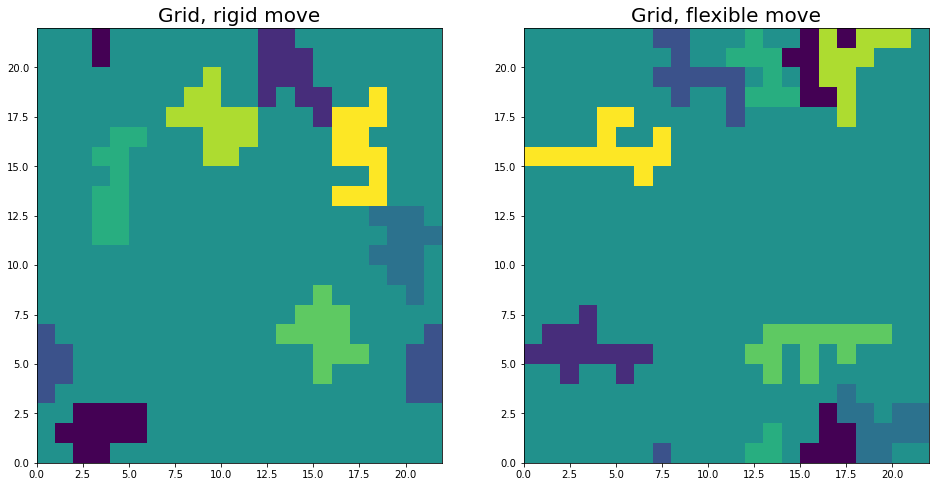

In [67]:
Ns = 30000
N = 22
M = 4
L = 13
T = 200


grid0, grid_flex, energy_flex = monte_carlo2(N, M, Ns, T, L, energy = True, flex = True)

# Plot rigid move and flexible move together
grid_rigid = np.load('2d_grid.npz')["arr_0"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
ax1.pcolormesh(grid_rigid)
ax2.pcolormesh(grid_flex)
ax1.set_title("Grid, rigid move", fontsize = 20)
ax2.set_title("Grid, flexible move", fontsize = 20)
plt.show()

As expected, the rigid polymers are less connected than the flexible ones, due to their lack of ability to change form whenever they collide. As we see in the top right corner of the flexible polymer grid, these polymers have a larger probability of getting entangled with one another, which causes for more clusters of polymers than in the rigid polymer grid.

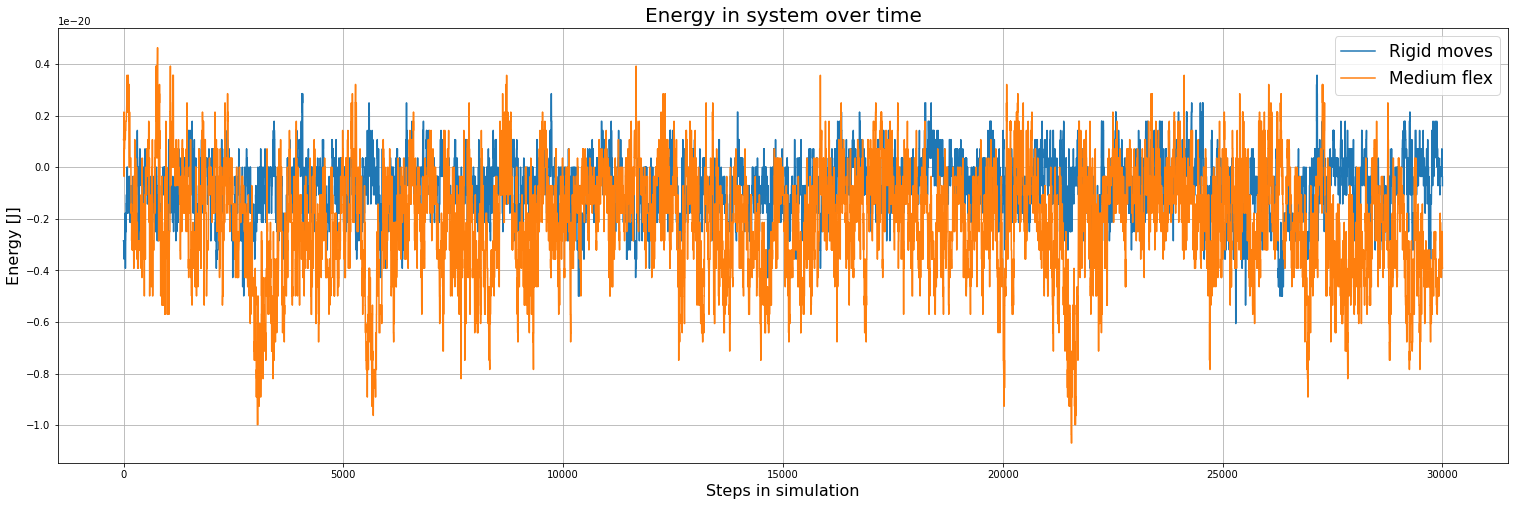

In [68]:
# Plot total system energy as a function of simulation steps
plt.figure(figsize = (26,8))
t = np.linspace(0,Ns-1,Ns)
plt.plot(t, energy_rigid)
plt.plot(t, energy_flex)
plt.title("Energy in system over time", fontsize = 20)
plt.xlabel("Steps in simulation", fontsize = 16)
plt.ylabel("Energy [J]", fontsize = 16)
plt.legend(["Rigid moves", "Medium flex"], prop={'size': 17})
plt.grid()

The first thing we notice from the energy plot above, is that the equilibrium energy when we use flexible movement is lower than the equilibrium energy for rigid move. When considering the physical placement of the polymers, this makes sense, as the polymers with flexible movement can adapt their shape when they hit another polymer, which in turn allows for more of their surface areas to connect. However, it is important to note that this can decrease or increase the total energy, depending on whether the polymers that connect have opposite or equal charge. But, since as the probability of connecting is higher when the polymers have opposite charge, the end result is a lower total system energy.

Another interesting observation is that the total system energy of the flexible polymers tend to vary more than the energy of the rigid polymers. This can be explained by the fact that the rigid polymers have less legal moves than the flexible ones, which means that the flexible polymers will move around more than the rigid, and thus the total energy has larger variations. The large variation is also a result of what we discussed in the previous paragaraph, since as for instance two polymers with equal charge may bump into each other, which causes for a local maximum in the energy plot.

### Correlation between multivalency, average number of clusters and average cluster size

Now we turn our focus to analyzing the formation of clusters, and the correlation between multivalency, average number of clusters and average cluster size. By cluster size we mean the total number of monomers in a given cluster. For the simulation below, we have decided to use the values $t_{equil}=60000$ and $n=400$, to ensure that A: the systems have reached equilibrium, and B: that the standard deviation is as small as possible. As we discussed previously, for $T = 200K$ we could not say for sure whether the system had reached equilibrium after 50000 iterations, whereas for $T = 500K$ it happened at about 15000 steps. Therefore, we think a safe choice is $t_{equil}=60000$. As for our choice of $n$, we found out earlier that $n=400$ gave accurate results for our first Monte Carlo simulation, and thus we estimate that it will give sufficiently accurate answers for this simulation as well.

In [127]:
T = 300
tr = 1000
N = 30
M = 5
Ls = np.linspace(3, 39, 13)
means_cs = []  # means for cluster size
means_nc = []  # means for number of clusters

# Variabler som selv kan velges
n = 400
te = 60000
Ns = int(te + n*tr)


for i, L in enumerate(Ls):
    grid0, grid, mean_sizes = monte_carlo2(N, M, Ns, T, L, flex = True, te = 60000, tr = 1000, cluster_size = True, energy = False)
    
    num_clusters_array = (2 * M * L) / mean_sizes
    mean_size_cluster = np.sum(num_clusters_array)/np.shape(mean_sizes)[0]    
    means_nc.append(mean_size_cluster)
    
    mean_size = np.sum(mean_sizes)/np.shape(mean_sizes)[0]
    means_cs.append(mean_size)

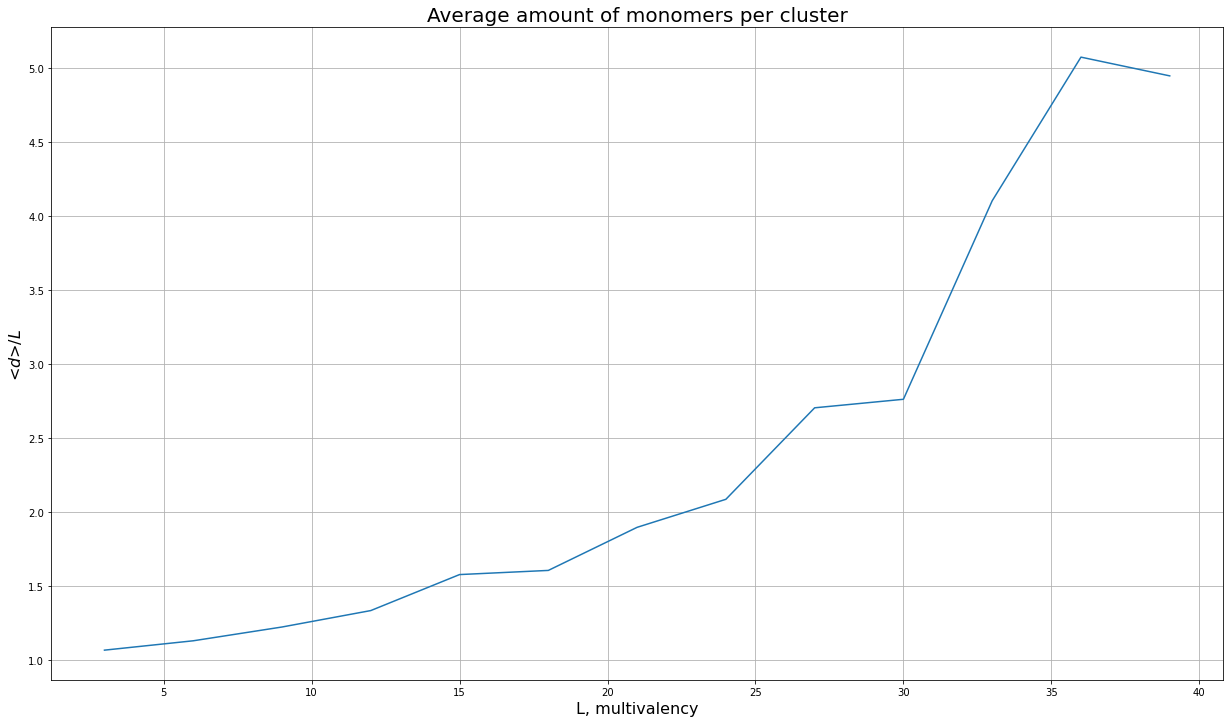

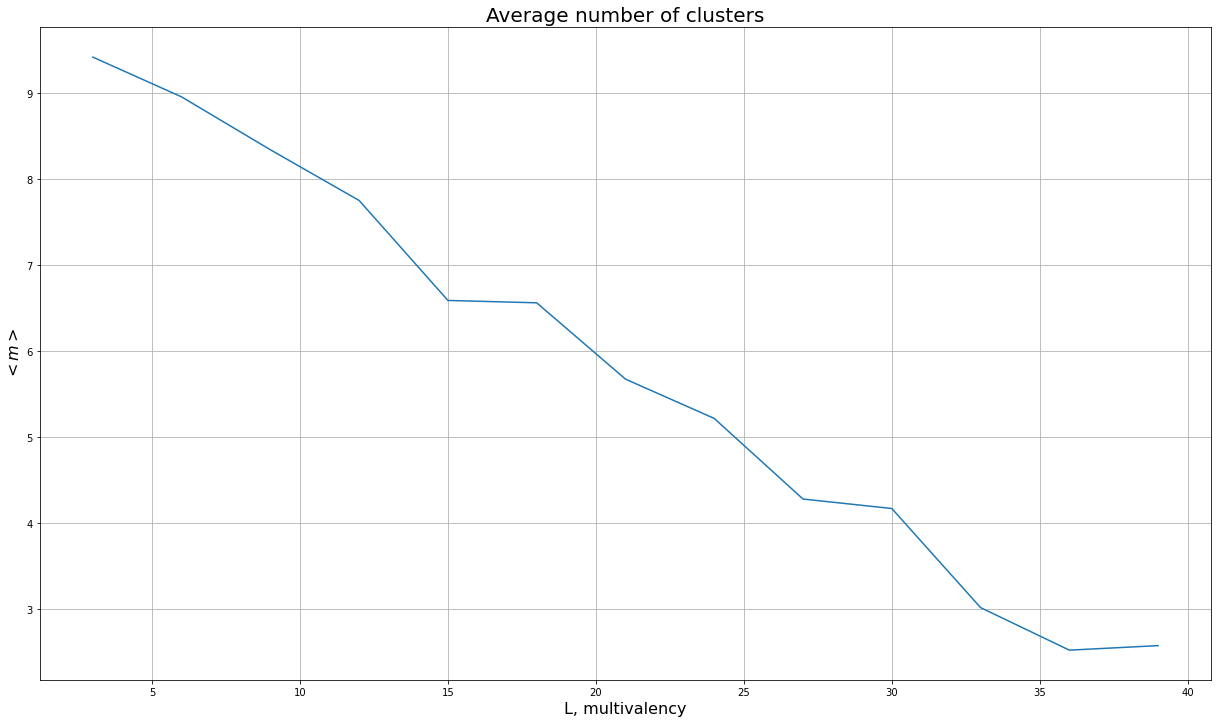

In [128]:
plt.figure(figsize = (21,12))
plt.plot(Ls, means_cs/Ls)
plt.title("Average amount of monomers per cluster", fontsize = 20)
plt.xlabel("L, multivalency", fontsize = 16)
plt.ylabel(r"<$d$>$/L$", fontsize = 16)
plt.grid()
plt.show()

plt.figure(figsize = (21,12))
plt.plot(Ls, means_nc)
plt.title("Average number of clusters", fontsize = 20)
plt.xlabel("L, multivalency", fontsize = 16)
plt.ylabel(r"$<m>$", fontsize = 16)
plt.grid()
plt.show()

As we see from the uppermost plot, the amount of monomers per cluster and multivalency, <$d$>$/L$ increases as the multivalency increases. This makes sense as the probability of a cluster connecting with another cluster, is larger when the cluster size increases compared to the grid size, which remains the same in all cases. For the two largest multivalencies, we see that the <$d$>$/L$ decreases, which we assume is a random result caused by the fact that the clusters are so large that a small increase in multivalency is overwhelmed by the limited space in the grid. As for the plot of <$m$>, the results imply the same: that as the multivalency increases, the polymers are more likely to make clusters as a larger part of the grid is covered by monomers.

In this simulation, we used the medium flexibility method of movement, which as we discussed earlier allows for the polymers to "merge" together by changing its shape. Thus, we would expect the medium flexibility function to cause a higher amount of clusters, and a lower amount of monomers per cluster. As seen from the "rigid move point of view", the polymers are here less likely to fit together, and so the average amount of monomers per cluster would be lower, and the average numbers of clusters would be higher.

It is also interesting to discuss for what values of L there will be a larger deviance in our results. Important for this analysis is realising that the size of our grid remains constant for all values of L. Looking at polymers with a greater multivalency, we take notice that these polymers will occupy a greater ratio of our grid, compared to polymers with lower multivalency. This means that these polymers are more likely to "meet" another polymer, as there are few empty spaces between polymers. The amount of clusters will therefore often be very low on average, and will not vary as there is only so many conformations of polymers that can occur with a higher amount of clusters. 

As for polymers with lower multivalency, there are a lot of different conformations that can be produced. This includes a larger variety of number of clusters and cluster size, as the ratio between the grid size and polymer size is not that limiting anymore.
It can therefore be argued that a higher multivalency will give a lower variation on our results, on average. 


Regarding the effects of different system parameters, we look closer at how changing the systems temperature will affect the formation of clusters. Firstly, we realize that temperature is directly related to $P_{move}$; the probability for polymers to move to a conformation with a higher total energy than before. If we increase the temperature, this probability will increase. This means that in general, polymers are more likely to move away from a cluster as temperature rise. For the same reason,it is more probable for polymers to get out of local energy minima. Ultimately, we therefore expect that an increase in temperature will destroy aggregate formation, resulting in a lower mean cluster size and a higher number of clusters. This becomes apparent if taken to the limit. If we let our temperature go towards infinity, we see that $P_{move}$ converges to 1. With $P_{move} = 1$, the system will basicly ignore any energybased calculation and move randomly around in the grid. Some clusters may be formed anyways, this depending on N and M, but will almost definetly do this to a lesser extent than it would for a lower temperature. 

As for low temperatures, we expect the opposite: that the polymer movement is highly dependent on the systems energy. Thus, the end-state of the system will depend more on the grid formed initially, since the polymers are less likely to escape any local energy minima; having a higher probability of getting stuck.